In [3]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 데이터 불러오기
data = pd.read_csv('machine.data_update.csv')


              MYCT          MMIN          MMAX        CACH       CHMIN  \
count   209.000000    209.000000    209.000000  209.000000  209.000000   
mean    203.822967   2867.980861  11796.153110   25.205742    4.698565   
std     260.262926   3878.742758  11726.564377   40.628722    6.816274   
min      17.000000     64.000000     64.000000    0.000000    0.000000   
25%      50.000000    768.000000   4000.000000    0.000000    1.000000   
50%     110.000000   2000.000000   8000.000000    8.000000    2.000000   
75%     225.000000   4000.000000  16000.000000   32.000000    6.000000   
max    1500.000000  32000.000000  64000.000000  256.000000   52.000000   

            CHMAX          PRP          ERP  
count  209.000000   209.000000   209.000000  
mean    18.267943   105.622010    99.330144  
std     25.997318   160.830733   154.757102  
min      0.000000     6.000000    15.000000  
25%      5.000000    27.000000    28.000000  
50%      8.000000    50.000000    45.000000  
75%     24.

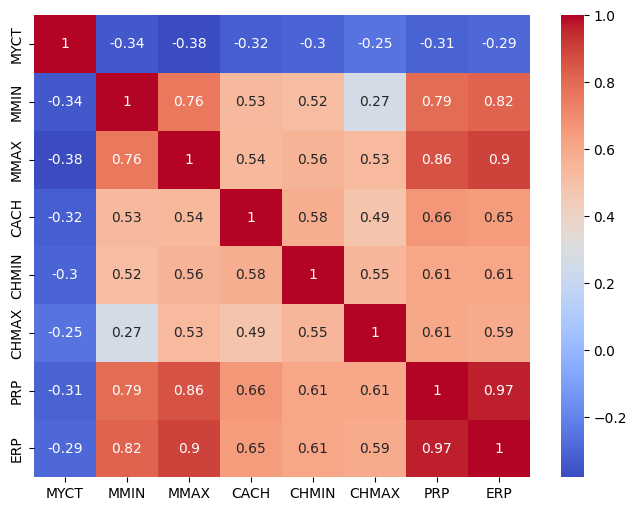

In [4]:
# 데이터 정보 출력
print(data.describe())

numeric_data = data.select_dtypes(include=np.number)
corr_matrix = numeric_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# 필요한 특성 선택
features = ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']
X = data[features]
y = data['PRP']



In [5]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 파이프라인 설정 및 학습
pipe = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=3)), ('model', LinearRegression())])
pipe.fit(X_train, y_train)



Pipeline(steps=[('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(degree=3)),
                ('model', LinearRegression())])

In [6]:
# 학습 데이터 평가
y_train_pred = pipe.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
print('Train MSE:', train_mse)
print('Train MAE:', train_mae)
print('Train R^2:', train_r2)

# 테스트 데이터 평가
y_test_pred = pipe.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print('Test MSE:', test_mse)
print('Test MAE:', test_mae)
print('Test R^2:', test_r2)



Train MSE: 372.783826854131
Train MAE: 13.768621575342467
Train R^2: 0.966255543943413
Test MSE: 5893482.591140021
Test MAE: 666.8637152777778
Test R^2: -101.92351085549872


In [7]:
param_grid = {'model__alpha': [0.01, 0.1, 1, 10, 100]}
lasso_pipe = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=2)), ('model', Lasso(max_iter=10000))])
grid_search = GridSearchCV(lasso_pipe, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# 최적의 모델 평가
best_lasso = grid_search.best_estimator_
y_train_pred_lasso = best_lasso.predict(X_train)
y_test_pred_lasso = best_lasso.predict(X_test)
train_r2_lasso = r2_score(y_train, y_train_pred_lasso)
test_r2_lasso = r2_score(y_test, y_test_pred_lasso)
print(f'Train R² (Lasso): {train_r2_lasso}')
print(f'Test R² (Lasso): {test_r2_lasso}')



Train R² (Lasso): 0.877202343351841
Test R² (Lasso): 0.7183210920325123


In [8]:
# 교차 검증
cv_scores_lasso = cross_val_score(best_lasso, X_train, y_train, cv=5, scoring='r2')
print(f"교차 검증 Lasso R² 점수: {cv_scores_lasso}")
print(f"교차 검증 Lasso R² 점수 평균: {cv_scores_lasso.mean()}")



교차 검증 Lasso R² 점수: [ 0.39187604  0.88767476  0.52168767  0.94178238 -0.53895608]
교차 검증 Lasso R² 점수 평균: 0.440812954093861


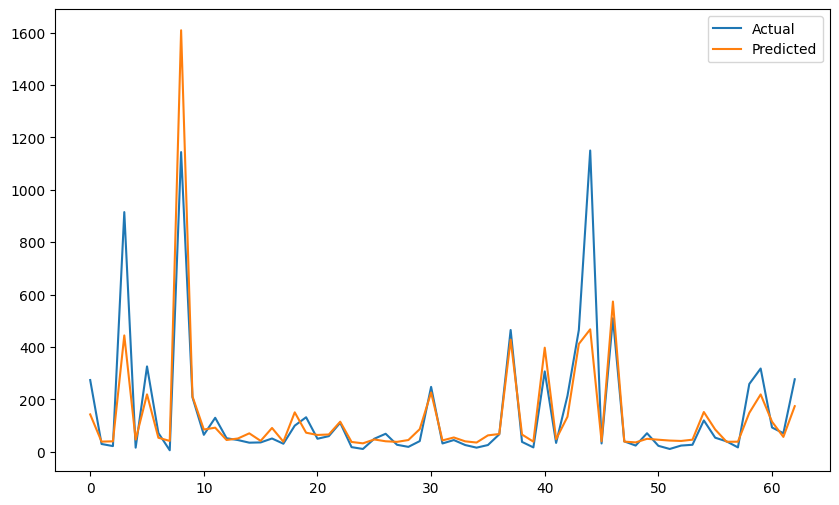

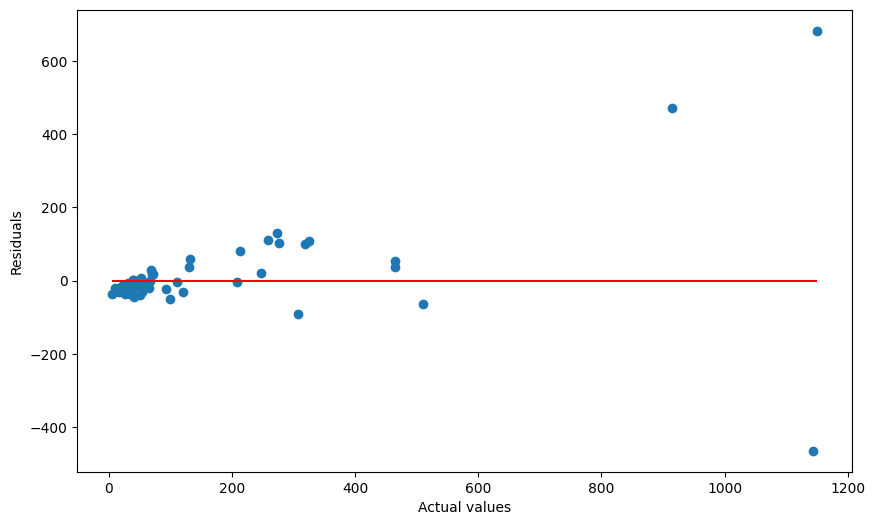

In [9]:
# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred_lasso, label='Predicted')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test - y_test_pred_lasso)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max(), colors='r')
plt.xlabel('Actual values')
plt.ylabel('Residuals')
plt.show()



In [10]:
# 기본 모델 성능 지표 저장
basic_model_performance = {
    'Train MSE': train_mse,
    'Train MAE': train_mae,
    'Train R^2': train_r2,
    'Test MSE': test_mse,
    'Test MAE': test_mae,
    'Test R^2': test_r2
}

# 최적화된 Lasso 모델 성능 지표 저장
optimized_model_performance = {
    'Train MSE': mean_squared_error(y_train, y_train_pred_lasso),
    'Train MAE': mean_absolute_error(y_train, y_train_pred_lasso),
    'Train R^2': r2_score(y_train, y_train_pred_lasso),
    'Test MSE': mean_squared_error(y_test, y_test_pred_lasso),
    'Test MAE': mean_absolute_error(y_test, y_test_pred_lasso),
    'Test R^2': r2_score(y_test, y_test_pred_lasso),
    'CV R^2 Mean': cv_scores_lasso.mean()
}



                         Train MSE  Train MAE  Train R^2      Test MSE  \
Basic Model             372.783827  13.768622   0.966256  5.893483e+06   
Optimized Lasso Model  1356.577812  24.005345   0.877202  1.612916e+04   

                         Test MAE    Test R^2  CV R^2 Mean  
Basic Model            666.863715 -101.923511          NaN  
Optimized Lasso Model   55.447824    0.718321     0.440813  


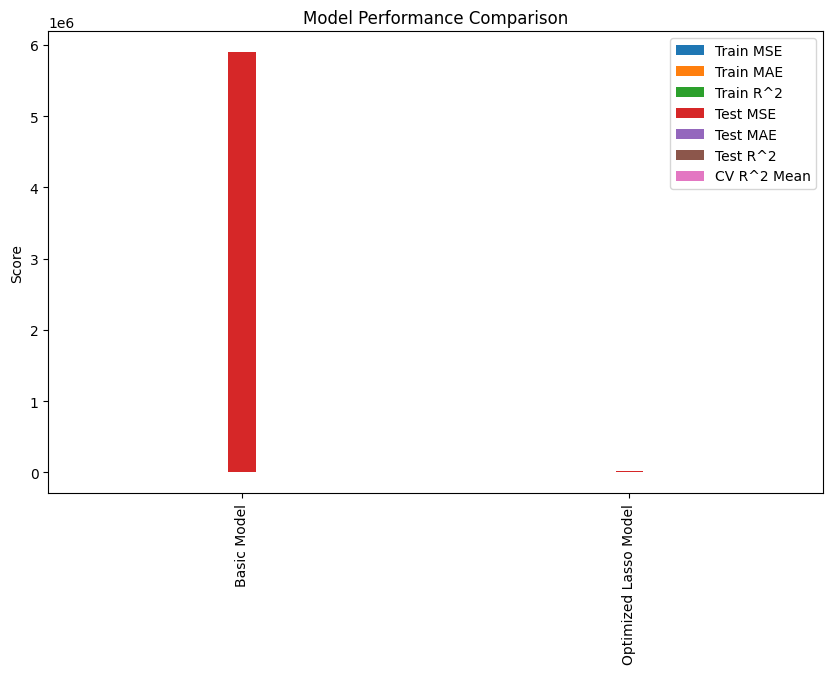

In [11]:
# 성능 지표 비교
performance_df = pd.DataFrame([basic_model_performance, optimized_model_performance], index=['Basic Model', 'Optimized Lasso Model'])
print(performance_df)

# 성능 지표 바 차트 시각화
performance_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.show()